Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Описание данных 

- date – дата совершения события

- event - событие

app_install – установка приложения
app_start – открыть приложения
registration – зарегистрироваться 
search – перейти на страницу поиска товаров (каталог)
open_item – открыть товар
choose_item – отправить товар в корзину
tap_basket – перейти в корзину
purchase – подтверждение покупки
- gender – пол пользователя

- os_name – платформа пользователя

- city – город пользователя

- device_id – идентификатор устройства пользователя

- urm_source – канал, с которого пришел пользователь

yandex-direct – Яндекс директ
google_ads – реклама в Google
vk_ads – реклама в ВК
instagram_ads – реклама в instagram
facebook_ads – реклама в facebook
referral – акция «приведи друга»
Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  
- purchase_sum – стоимость покупки (при совершении события ‘purchase’)

Обратите внимание на следующее:

- В выгрузке только уникальные действия пользователей за каждый день 

- Можно миновать стадию установки приложения, если оно было установлено ранее

- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

In [1]:
import pandas as pd
from datetime import timedelta, datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Product economics/KC_case_data .csv', sep=',')

In [3]:
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


#### 1. Вычислить MAU февраля

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
mau = df.loc[(df['date'] >= '2020-02-01') & (df['date'] <= '2020-02-29')] \
        .groupby('event', as_index=False) \
        .agg({'device_id': 'nunique'})
mau

,event,device_id
0,app_install,38078
1,app_start,75032
2,choose_item,61813
3,purchase,27902
4,register,20578
5,search,72666
6,tap_basket,50352


Ответ: 75032

#### 2. Количество установок в январе

In [7]:
installs = df.loc[(df['date'] >= '2020-01-01') & (df['date'] <= '2020-01-31')] \
             .groupby('event', as_index=False) \
             .agg({'device_id': 'nunique'})
installs

,event,device_id
0,app_install,80297
1,app_start,99161
2,choose_item,81872
3,purchase,39012
4,register,42946
5,search,95988
6,tap_basket,66720


Ответ: 80297

#### 3. Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей? Ответ впишите в формате: дд.мм.гггг

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

#### 4. Укажите значение CR из предыдущего вопроса в % (округлите до 1 цифры после запятой). Формат числа - с точкой.

In [8]:
ins = df[df['event'] == 'app_install'][['date', 'device_id']]

In [9]:
ins = ins.drop_duplicates('device_id')

In [10]:
ins = ins.rename(columns={'date': 'install_date'})

In [11]:
df = df.merge(ins, how='left', on='device_id')

In [12]:
purchases = df[df['event'] == 'purchase'][['date', 'device_id']]
purchases = purchases.sort_values('date').drop_duplicates('device_id')
purchases = purchases.rename(columns={'date': 'first_purchase_date'})

In [13]:
df = df.merge(purchases, how='left', on='device_id')

In [14]:
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,first_purchase_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,NaT,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,NaT
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,NaT
...,...,...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-28,2020-03-31
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31,2020-03-31
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31,2020-03-31
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads,2020-03-06,2020-03-31


In [15]:
df['diff'] = df['first_purchase_date'] - df['install_date']
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,first_purchase_date,diff
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,2020-01-07,6 days
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,2020-01-01,0 days
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,NaT,2020-01-01,NaT
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,NaT,NaT
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-28,2020-03-31,3 days
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31,2020-03-31,0 days
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31,2020-03-31,0 days
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads,2020-03-06,2020-03-31,25 days


In [16]:
df_conv = df.loc[(df['diff'] <= '7 days')]
df_conv

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,first_purchase_date,diff
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,2020-01-07,6 days
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,2020-01-01,0 days
8,2020-01-01,app_start,NaN,ios,10144701,female,Moscow,-,2020-01-01,2020-01-01,0 days
11,2020-01-01,app_start,NaN,android,12374612,male,Moscow,-,2020-01-01,2020-01-01,0 days
12,2020-01-01,app_start,NaN,ios,12424502,female,Saint-Petersburg,yandex-direct,2020-01-01,2020-01-02,1 days
...,...,...,...,...,...,...,...,...,...,...,...
2747962,2020-03-31,register,NaN,android,9613546,female,Moscow,google_ads,2020-03-31,2020-03-31,0 days
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-28,2020-03-31,3 days
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31,2020-03-31,0 days
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31,2020-03-31,0 days


In [17]:
df_all = df.loc[df.event == 'app_install']\
           .groupby(['date'], as_index=False)\
           .agg({'device_id': 'nunique'})\
           .sort_values('device_id', ascending=False)
df_all

,date,device_id
9,2020-01-10,13106
65,2020-03-06,6358
13,2020-01-14,5173
12,2020-01-13,4571
10,2020-01-11,4523
...,...,...
63,2020-03-04,452
73,2020-03-14,443
76,2020-03-17,431
64,2020-03-05,411


In [18]:
df_conv = df_conv.loc[df_conv.event == 'app_install']\
                 .groupby(['date'], as_index=False)\
                 .agg({'device_id': 'nunique'})\
                 .sort_values('device_id', ascending=False)                
df_conv

,date,device_id
9,2020-01-10,4161
13,2020-01-14,1973
12,2020-01-13,1715
14,2020-01-15,1650
10,2020-01-11,1521
...,...,...
74,2020-03-15,125
73,2020-03-14,120
64,2020-03-05,115
76,2020-03-17,108


In [19]:
df_1 = df_all.merge(df_conv, on='date')
df_1['cr'] = (df_1['device_id_y'] / df_1['device_id_x'] * 100).round(2)
df_1.sort_values('cr', ascending=False)

,date,device_id_x,device_id_y,cr
7,2020-01-01,3579,1408,39.34
35,2020-01-09,1424,558,39.19
5,2020-01-15,4310,1650,38.28
2,2020-01-14,5173,1973,38.14
9,2020-01-02,3144,1186,37.72
...,...,...,...,...
52,2020-03-18,1171,235,20.07
54,2020-03-29,1117,223,19.96
44,2020-03-22,1261,251,19.90
57,2020-03-28,1091,209,19.16


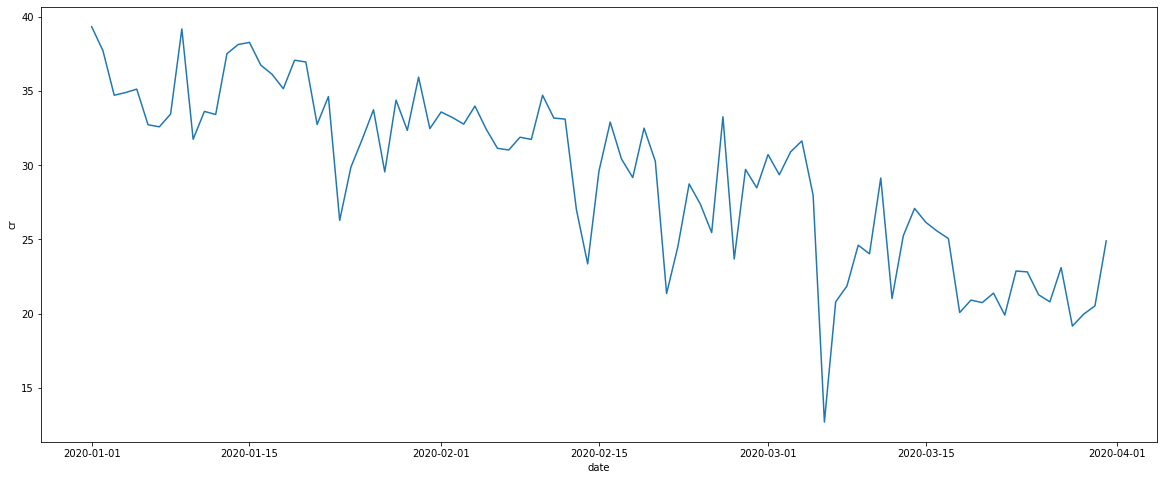

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(data=df_1, x="date", y="cr", ax=ax)
plt.show()

Ответ: 01.01.2020, cr = 39.34% 

#### 5. С какого платного маркетингового канала пришло больше всего новых пользователей? 

In [21]:
new_users = df.loc[df.event == 'app_install']\
                 .groupby(['utm_source'], as_index=False)\
                 .agg({'device_id': 'nunique'})\
                 .sort_values('device_id', ascending=False)
new_users

,utm_source,device_id
0,-,32460
6,yandex-direct,29368
2,google_ads,26286
5,vk_ads,23189
3,instagram_ads,20096
1,facebook_ads,13916
4,referal,9282


Ответ: Яндекс

#### 6. Проанализируйте на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрите отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. На каком шаге отваливается больше всего зарегистрированных пользователей?

В ответ впишите один из шагов, конверсия из которого (в следующий шаг) самая низкая, в таком формате: «Поиск», «Добавление товара», «Переход в корзину», «Регистрация».

Подсказка: 

- Для того, чтобы выделить группу тех, кому нужно и не нужно регистрироваться, добавьте колонку с датой регистрации. Если дата регистрации < даты совершения события, то пользователь уже зарегистрирован. 



In [22]:
first_reg = df[df['event'] == 'register'][['date', 'device_id']].sort_values('date').drop_duplicates('device_id')
df['first_reg'] = df['device_id'].map(first_reg.set_index('device_id')['date'])

In [23]:
already_reg = df[df['first_reg'] < df['date']]

In [24]:
already_reg.groupby('event')['device_id'].nunique()

event
app_start      40991
choose_item    37926
purchase       24880
search         40482
tap_basket     34517
Name: device_id, dtype: int64

In [25]:
print('Конверсия в поиск из открытия', round((40482/40991) * 100, 2))
print('Конверсия в добавление товара из поиска', round((37926/40482) * 100, 2))
print('Конверсия в переход в корзину из добавления товара', round((34517/37926) * 100, 2))
print('Конверсия в покупку из перехода в корзину', round((24880/34517) * 100, 2))

Конверсия в поиск из открытия 98.76
Конверсия в добавление товара из поиска 93.69
Конверсия в переход в корзину из добавления товара 91.01
Конверсия в покупку из перехода в корзину 72.08


Ответ: переход в корзину

#### 7. Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм», «Реферальная программа».

Подсказка: 

- CR = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

In [26]:
start = df.loc[df.event == 'app_start']\
          .groupby(['utm_source'], as_index=False)\
          .agg({'device_id': 'nunique'})\
          .sort_values('device_id', ascending=False)
start

,utm_source,device_id
0,-,52268
6,yandex-direct,40707
2,google_ads,38092
5,vk_ads,34079
3,instagram_ads,31045
1,facebook_ads,25957
4,referal,15924


In [27]:
purch = df.loc[df.event == 'purchase']\
          .groupby(['utm_source'], as_index=False)\
          .agg({'device_id': 'nunique'})\
          .sort_values('device_id', ascending=False)
purch

,utm_source,device_id
0,-,16598
5,vk_ads,12364
6,yandex-direct,12028
2,google_ads,11339
3,instagram_ads,10762
1,facebook_ads,9017
4,referal,6362


In [28]:
bad_source = start.merge(purch, on='utm_source')
bad_source['cr'] = (bad_source['device_id_y'] / bad_source['device_id_x'] * 100).round(2)
bad_source.sort_values('cr')

,utm_source,device_id_x,device_id_y,cr
1,yandex-direct,40707,12028,29.55
2,google_ads,38092,11339,29.77
0,-,52268,16598,31.76
4,instagram_ads,31045,10762,34.67
5,facebook_ads,25957,9017,34.74
3,vk_ads,34079,12364,36.28
6,referal,15924,6362,39.95


Ответ: Яндекс

#### 8. Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? (учитываются только первые покупки пользователей)

In [29]:
avg_check = df[df['event'] == 'purchase'][['date', 'device_id', 'purchase_sum', 'utm_source']]
avg_check = avg_check.sort_values('date').drop_duplicates('device_id')

In [30]:
avg_check.groupby('utm_source').median()

,device_id,purchase_sum
utm_source,,
-,10972119.0,398.5
facebook_ads,10844491.0,389.0
google_ads,11089575.0,390.5
instagram_ads,11096726.0,393.5
referal,10491527.0,395.5
vk_ads,11334978.0,393.0
yandex-direct,10969061.5,392.5


Ответ: реферальная программа

#### 9. Данные по затратам на рекламу:

Яндекс – 10 491 707 руб.
Гугл – 10 534 878 руб.
Фейсбук – 8 590 498 руб.
Инстаграм – 8 561626 руб.
ВК – 9 553 531руб.

Какой платный канал привлечения (среди рекламных) имеет самый высокий ROMI? 

В ответ впишите один из каналов в таком формате: «Яндекс», «Гугл», «ВК», «Фейсбук», «Инстаграм».

In [32]:
df.groupby('utm_source')['purchase_sum'].sum()

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [33]:
print('ROMI Facebook:', round((12249901/8590498 - 1) * 100, 2), '%')
print('ROMI Google:', round((12868276/10534878 - 1) * 100, 2), '%')
print('ROMI Instagram:', round((14546969/8561626 - 1) * 100, 2), '%')
print('ROMI VK:', round((16389652.5/9553531 - 1) * 100, 2), '%')
print('ROMI Yandex:', round((13915368/10491707 - 1) * 100, 2), '%')

ROMI Facebook: 42.6 %
ROMI Google: 22.15 %
ROMI Instagram: 69.91 %
ROMI VK: 71.56 %
ROMI Yandex: 32.63 %


Ответ: ВК